In [6]:
# Import necessary libraries
import os
import sys

# Add the scripts folder to the Python path
sys.path.append(os.path.abspath("../scripts"))
import pandas as pd
from load_data import fetch_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from visualizations import plot_cluster_metrics,aggregate_application_traffic,get_top_users_by_traffic,plot_top_users,plot_top_3_apps,calculate_inertia, plot_elbow_curve, perform_kmeans_clustering
from sklearn.preprocessing import StandardScaler

In [7]:

# SQL query to fetch data
query = "SELECT * FROM xdr_data ;"  

# Load the data
df = fetch_data(query)

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\load_data.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [8]:

# Aggregate the metrics
aggregated_metrics = df.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Total session duration per customer
    'Total DL (Bytes)': 'sum',  # Total download traffic per customer
    'Total UL (Bytes)': 'sum',  # Total upload traffic per customer
}).reset_index()



In [9]:
# Calculate session frequency
session_frequency = df['MSISDN/Number'].value_counts().reset_index()
session_frequency.columns = ['MSISDN/Number', 'Session Frequency']




In [10]:
# Merge session frequency with other metrics
aggregated_metrics = pd.merge(aggregated_metrics, session_frequency, on='MSISDN/Number')

# Calculate total traffic (Download + Upload)
aggregated_metrics['Total Traffic (Bytes)'] = aggregated_metrics['Total DL (Bytes)'] + aggregated_metrics['Total UL (Bytes)']



In [11]:
# Sort the aggregated data by each metric for ranking
top_10_duration = aggregated_metrics.sort_values(by='Dur. (ms)', ascending=False).head(10)
top_10_traffic = aggregated_metrics.sort_values(by='Total Traffic (Bytes)', ascending=False).head(10)
top_10_frequency = aggregated_metrics.sort_values(by='Session Frequency', ascending=False).head(10)



In [12]:
# Display the top 10 customers for each metric
print("Top 10 Customers by Session Duration:")
print(top_10_duration)

print("\nTop 10 Customers by Total Traffic:")
print(top_10_traffic)

print("\nTop 10 Customers by Session Frequency:")
print(top_10_frequency)

Top 10 Customers by Session Duration:
       MSISDN/Number   Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  \
13180   3.362578e+10  18553754.0      7.770043e+09       729577380.0   
6437    3.361489e+10   9966898.0      8.156743e+09       689483001.0   
92923   3.376054e+10   9279434.0      7.811295e+09       703478581.0   
13526   3.362632e+10   8791927.0      7.301517e+09       669650721.0   
65118   3.366716e+10   8744914.0      5.052068e+09       566326364.0   
50281   3.366284e+10   6614270.0      3.593674e+09       406424372.0   
57160   3.366469e+10   6288730.0      5.279827e+09       402180804.0   
666     3.360313e+10   6287761.0      4.540607e+09       435587631.0   
66029   3.366746e+10   5649882.0      2.334299e+09       266222647.0   
92577   3.376041e+10   5321667.0      6.610852e+09       521518890.0   

       Session Frequency  Total Traffic (Bytes)  
13180                 17           8.499621e+09  
6437                  17           8.846226e+09  
92923              

In [13]:


# Select the metrics for normalization
metrics_to_normalize = ['Session Frequency', 'Dur. (ms)', 'Total Traffic (Bytes)']

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the metrics
normalized_data = scaler.fit_transform(aggregated_metrics[metrics_to_normalize])

# Convert normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=metrics_to_normalize)

# Add the MSISDN/Number column to the normalized DataFrame for reference
normalized_df['MSISDN/Number'] = aggregated_metrics['MSISDN/Number']




In [14]:
# Display the first few rows of the normalized data
print("Normalized Data:")
print(normalized_df.head())

Normalized Data:
   Session Frequency  Dur. (ms)  Total Traffic (Bytes)  MSISDN/Number
0           0.000000   0.005908               0.095931   3.360100e+10
1           0.000000   0.009387               0.014026   3.360100e+10
2           0.000000   0.006892               0.063851   3.360100e+10
3           0.000000   0.002304               0.044148   3.360101e+10
4           0.058824   0.001615               0.161598   3.360101e+10


In [15]:


# Initialize the K-Means model with k=3
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model on the normalized metrics
kmeans.fit(normalized_data)

# Add the cluster labels to the original data
aggregated_metrics['Cluster'] = kmeans.labels_

# Display the first few rows with cluster assignments
print("Aggregated Metrics with Clusters:")
print(aggregated_metrics.head())

# Display the number of customers in each cluster
print("\nNumber of Customers in Each Cluster:")
print(aggregated_metrics['Cluster'].value_counts())


d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Yoni\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Yoni\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child

Aggregated Metrics with Clusters:
   MSISDN/Number  Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  \
0   3.360100e+10   116720.0      8.426375e+08        36053108.0   
1   3.360100e+10   181230.0      1.207552e+08        36104459.0   
2   3.360100e+10   134969.0      5.566597e+08        39306820.0   
3   3.360101e+10    49878.0      4.019932e+08        20327526.0   
4   3.360101e+10    37104.0      1.363130e+09        94280527.0   

   Session Frequency  Total Traffic (Bytes)  Cluster  
0                  1           8.786906e+08        2  
1                  1           1.568596e+08        2  
2                  1           5.959665e+08        2  
3                  1           4.223207e+08        2  
4                  2           1.457411e+09        0  

Number of Customers in Each Cluster:
Cluster
2    81158
0    21630
1     4068
Name: count, dtype: int64


In [16]:
# Define the metrics for analysis
metrics = ['Dur. (ms)', 'Total Traffic (Bytes)', 'Session Frequency']

# Compute summary statistics for each cluster
cluster_summary = aggregated_metrics.groupby('Cluster')[metrics].agg(['min', 'max', 'mean', 'sum'])

# Display the summary statistics
print("Cluster Summary Statistics:")
print(cluster_summary)


Cluster Summary Statistics:
        Dur. (ms)                                           \
              min         max           mean           sum   
Cluster                                                      
0         18235.0   3174824.0  213600.528202  4.620179e+09   
1         46896.0  18553754.0  569329.970747  2.316034e+09   
2          7142.0   1573420.0  106984.202543  8.682624e+09   

        Total Traffic (Bytes)                                            \
                          min           max          mean           sum   
Cluster                                                                   
0                2.842182e+08  1.873330e+09  1.125421e+09  2.434285e+13   
1                1.085994e+09  8.846226e+09  2.280321e+09  9.276344e+12   
2                3.324901e+07  9.507607e+08  4.955057e+08  4.021425e+13   

        Session Frequency                       
                      min max      mean    sum  
Cluster                                         
0

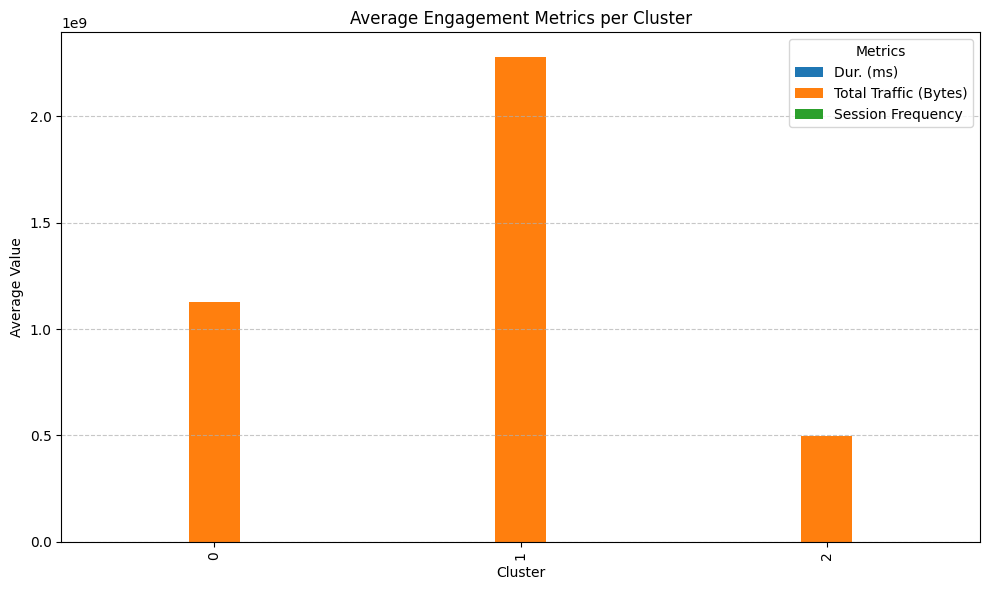

In [17]:
# Metrics to visualize
metrics = ['Dur. (ms)', 'Total Traffic (Bytes)', 'Session Frequency']

# Call the plotting function
plot_cluster_metrics(aggregated_metrics, metrics)


In [18]:
application_columns = {
    "Youtube": ("Youtube DL (Bytes)", "Youtube UL (Bytes)"),
    "Netflix": ("Netflix DL (Bytes)", "Netflix UL (Bytes)"),
    "Gaming": ("Gaming DL (Bytes)", "Gaming UL (Bytes)"),
    "Other": ("Other DL (Bytes)", "Other UL (Bytes)")
}


In [19]:
top_users = aggregate_application_traffic(df, application_columns)


In [20]:
for app, users in top_users.items():
    print(f"Top 10 Users for {app}:\n", users)


Top 10 Users for Youtube:
        MSISDN/Number  Youtube_Total_Traffic
13180   3.362578e+10            452958769.0
92923   3.376054e+10            396289198.0
6437    3.361489e+10            394370218.0
13526   3.362632e+10            374483047.0
76363   3.367588e+10            317410572.0
65118   3.366716e+10            315231310.0
13994   3.362708e+10            308790774.0
92577   3.376041e+10            303169107.0
86455   3.369879e+10            302661958.0
666     3.360313e+10            284090139.0
Top 10 Users for Netflix:
         MSISDN/Number  Netflix_Total_Traffic
37052    3.365973e+10            399519079.0
6437     3.361489e+10            361401046.0
13180    3.362578e+10            356980607.0
92923    3.376054e+10            334643269.0
13526    3.362632e+10            328725740.0
92577    3.376041e+10            318347546.0
65118    3.366716e+10            313939488.0
76363    3.367588e+10            309093159.0
106137   3.378632e+10            305939790.0
94654    3.3

In [21]:
# Get top 10 users by YouTube download traffic
top_10_users_youtube_dl = (
    df[['MSISDN/Number', 'Youtube DL (Bytes)']]
    .sort_values('Youtube DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by YouTube upload traffic
top_10_users_youtube_ul = (
    df[['MSISDN/Number', 'Youtube UL (Bytes)']]
    .sort_values('Youtube UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Social Media download traffic
top_10_users_social_media_dl = (
    df[['MSISDN/Number', 'Social Media DL (Bytes)']]
    .sort_values('Social Media DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Social Media upload traffic
top_10_users_social_media_ul = (
    df[['MSISDN/Number', 'Social Media UL (Bytes)']]
    .sort_values('Social Media UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Google download traffic
top_10_users_google_dl = (
    df[['MSISDN/Number', 'Google DL (Bytes)']]
    .sort_values('Google DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Google upload traffic
top_10_users_google_ul = (
    df[['MSISDN/Number', 'Google UL (Bytes)']]
    .sort_values('Google UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Email download traffic
top_10_users_email_dl = (
    df[['MSISDN/Number', 'Email DL (Bytes)']]
    .sort_values('Email DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Email upload traffic
top_10_users_email_ul = (
    df[['MSISDN/Number', 'Email UL (Bytes)']]
    .sort_values('Email UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Netflix download traffic
top_10_users_netflix_dl = (
    df[['MSISDN/Number', 'Netflix DL (Bytes)']]
    .sort_values('Netflix DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Netflix upload traffic
top_10_users_netflix_ul = (
    df[['MSISDN/Number', 'Netflix UL (Bytes)']]
    .sort_values('Netflix UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Gaming download traffic
top_10_users_gaming_dl = (
    df[['MSISDN/Number', 'Gaming DL (Bytes)']]
    .sort_values('Gaming DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Gaming upload traffic
top_10_users_gaming_ul = (
    df[['MSISDN/Number', 'Gaming UL (Bytes)']]
    .sort_values('Gaming UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Other download traffic
top_10_users_other_dl = (
    df[['MSISDN/Number', 'Other DL (Bytes)']]
    .sort_values('Other DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by Other upload traffic
top_10_users_other_ul = (
    df[['MSISDN/Number', 'Other UL (Bytes)']]
    .sort_values('Other UL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by total download traffic
top_10_users_total_dl = (
    df[['MSISDN/Number', 'Total DL (Bytes)']]
    .sort_values('Total DL (Bytes)', ascending=False)
    .head(10)
)

# Get top 10 users by total upload traffic
top_10_users_total_ul = (
    df[['MSISDN/Number', 'Total UL (Bytes)']]
    .sort_values('Total UL (Bytes)', ascending=False)
    .head(10)
)


d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


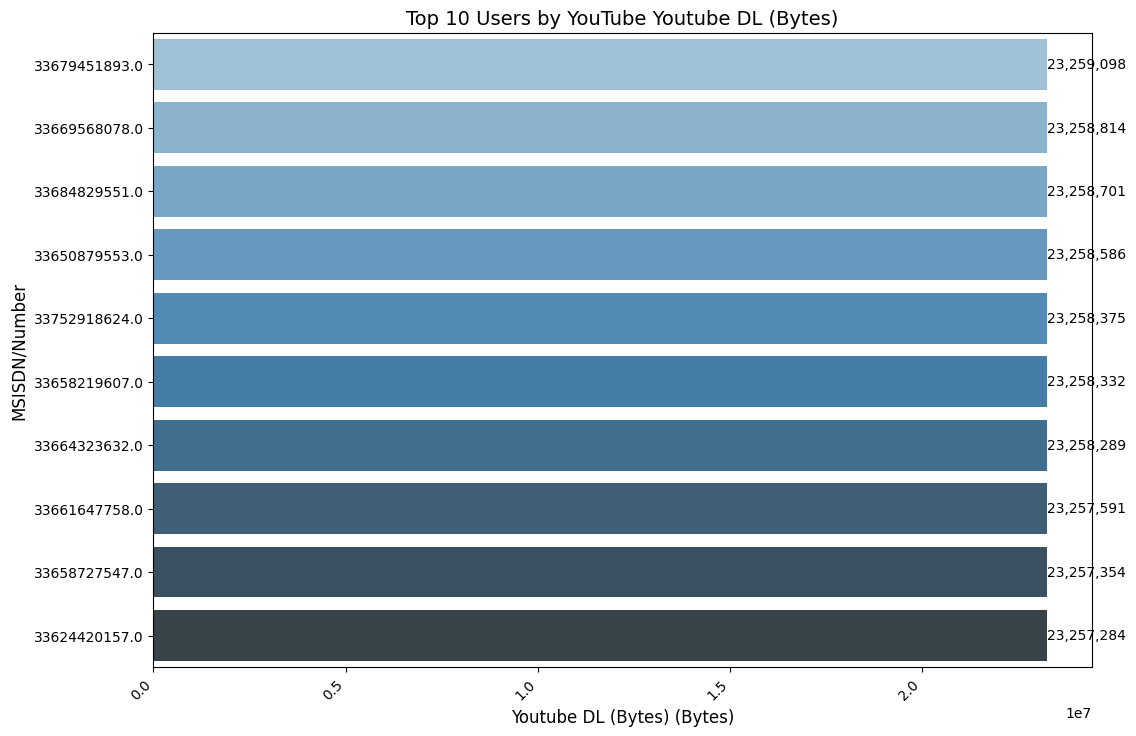

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


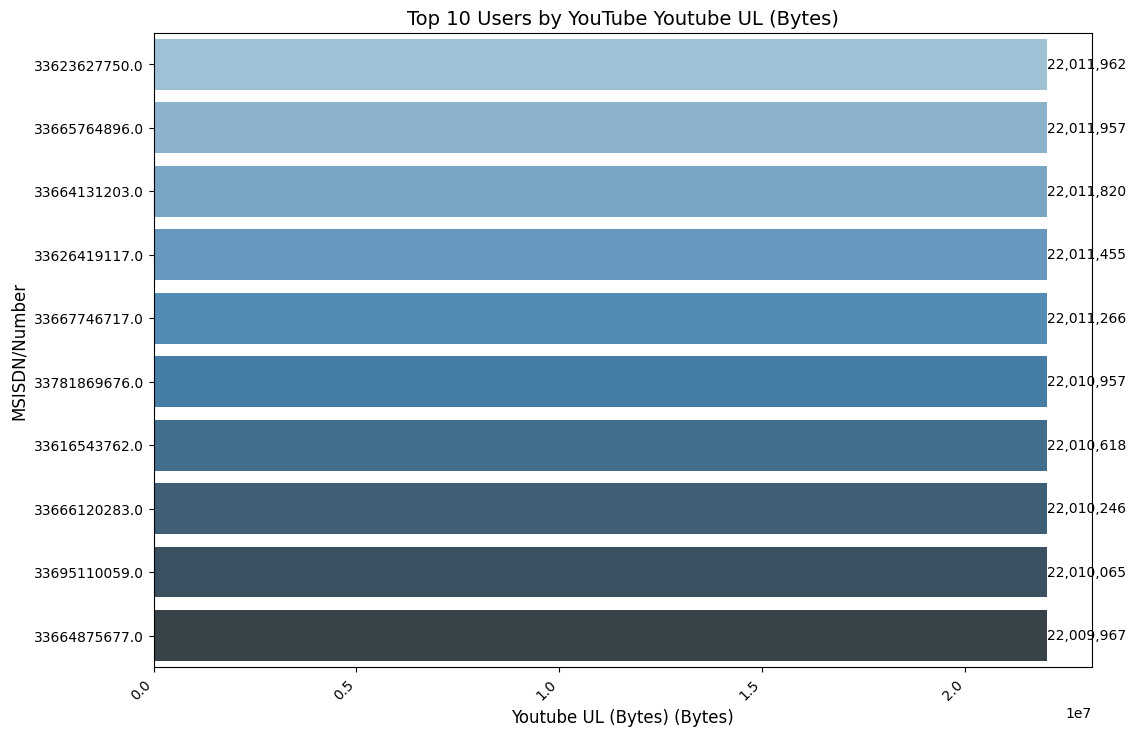

In [22]:
# Visualizing YouTube top 10 users (download and upload)
plot_top_users(top_10_users_youtube_dl, "YouTube", "Youtube DL (Bytes)")
plot_top_users(top_10_users_youtube_ul, "YouTube", "Youtube UL (Bytes)")

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


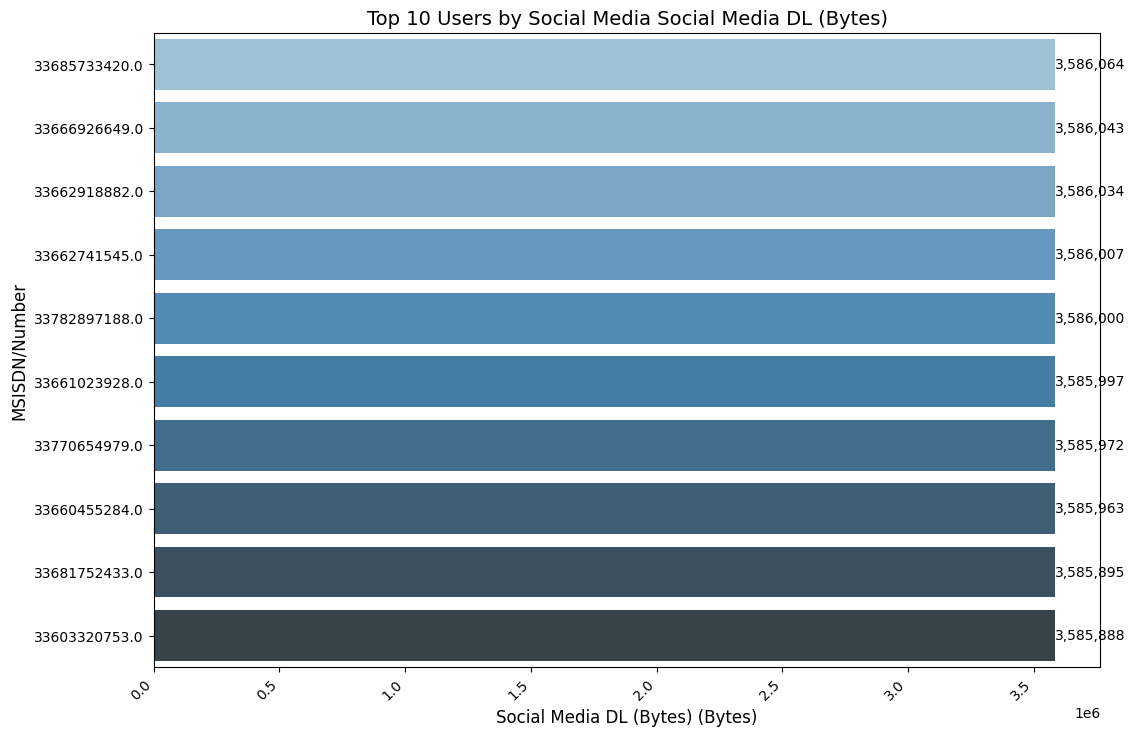

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


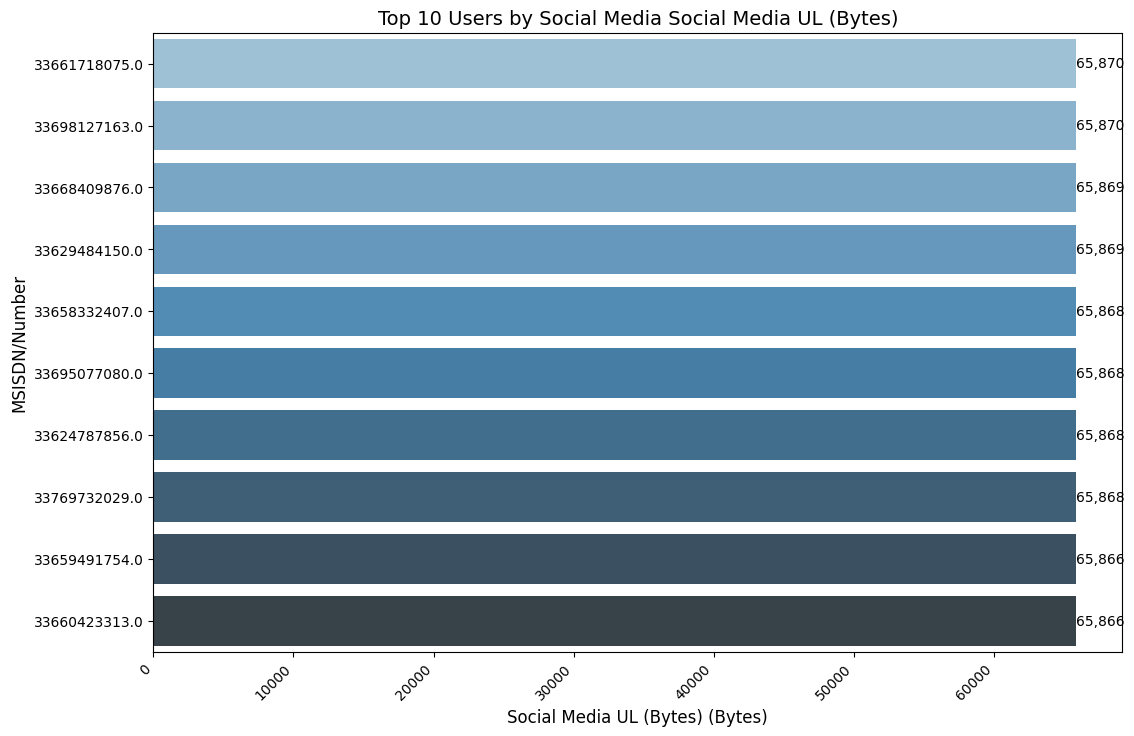

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


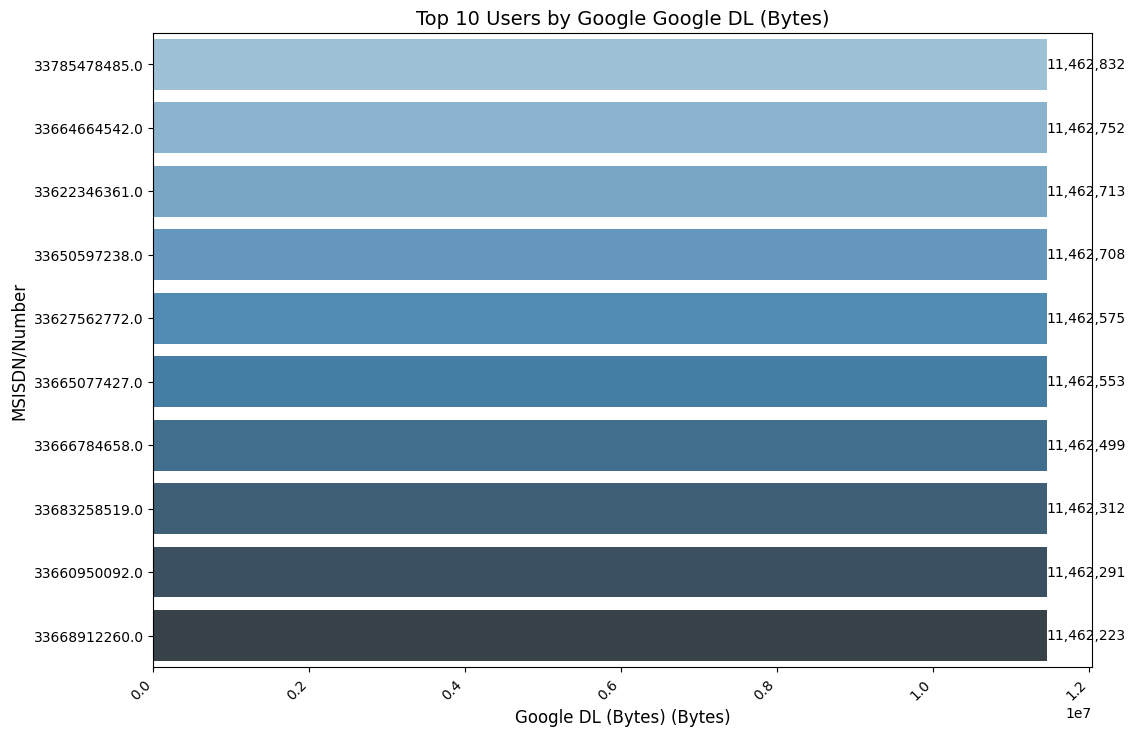

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


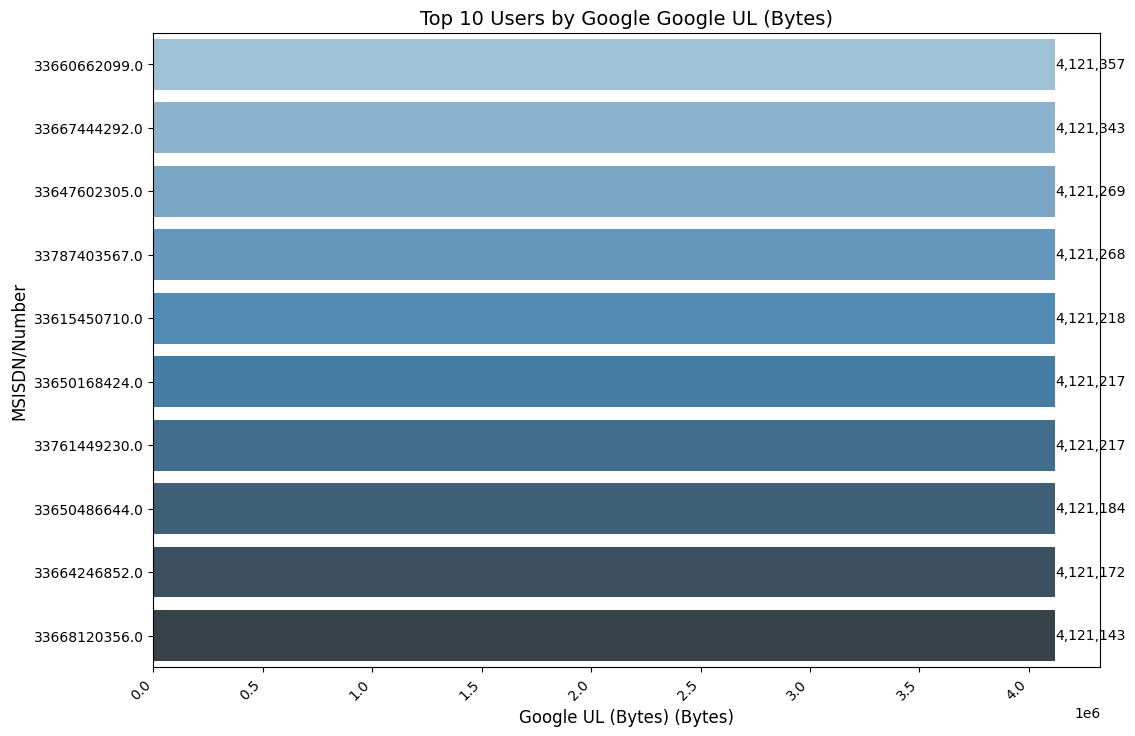

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


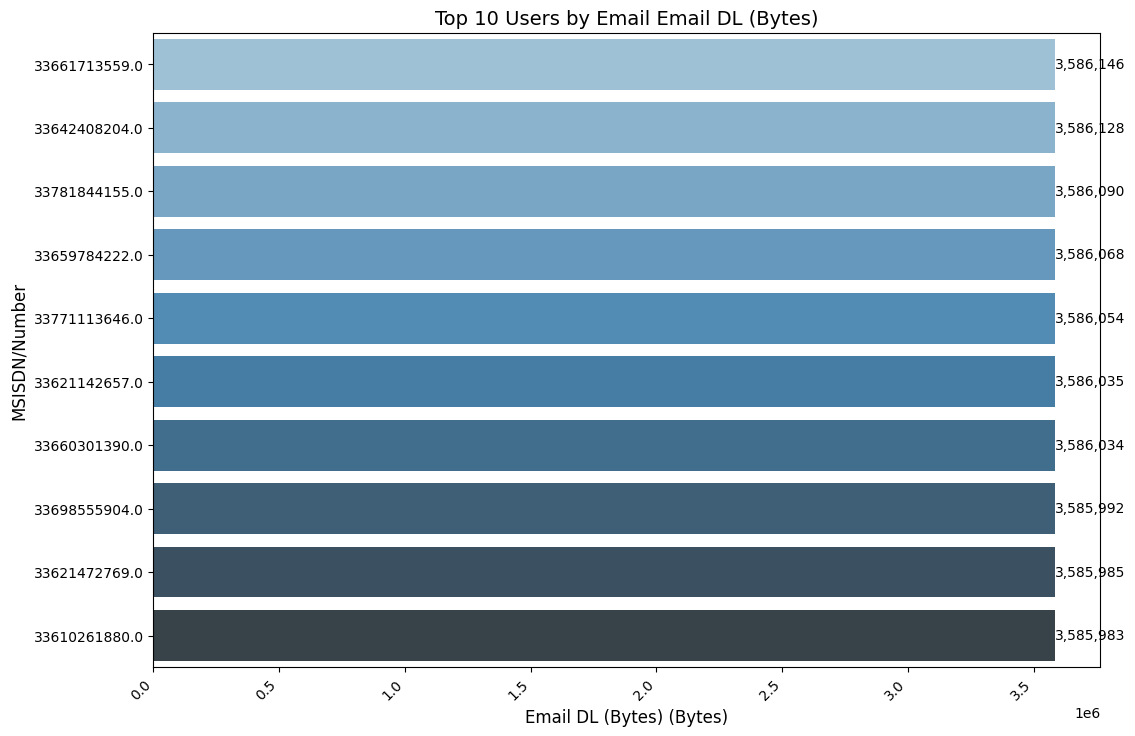

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


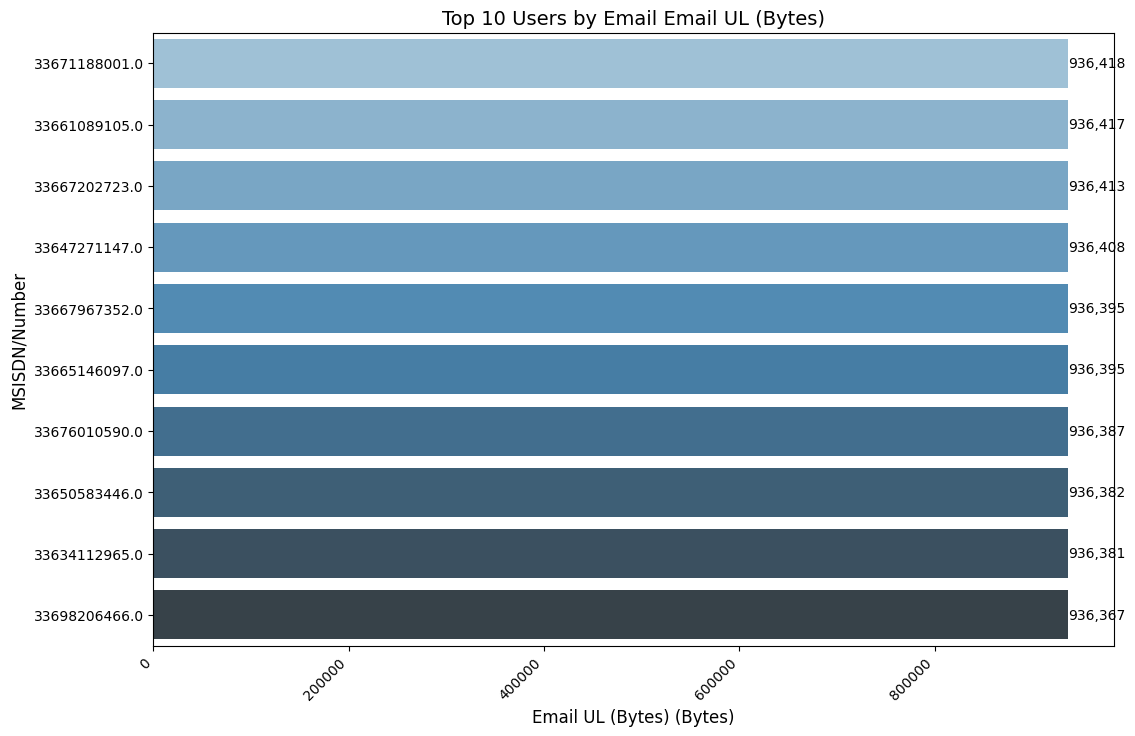

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


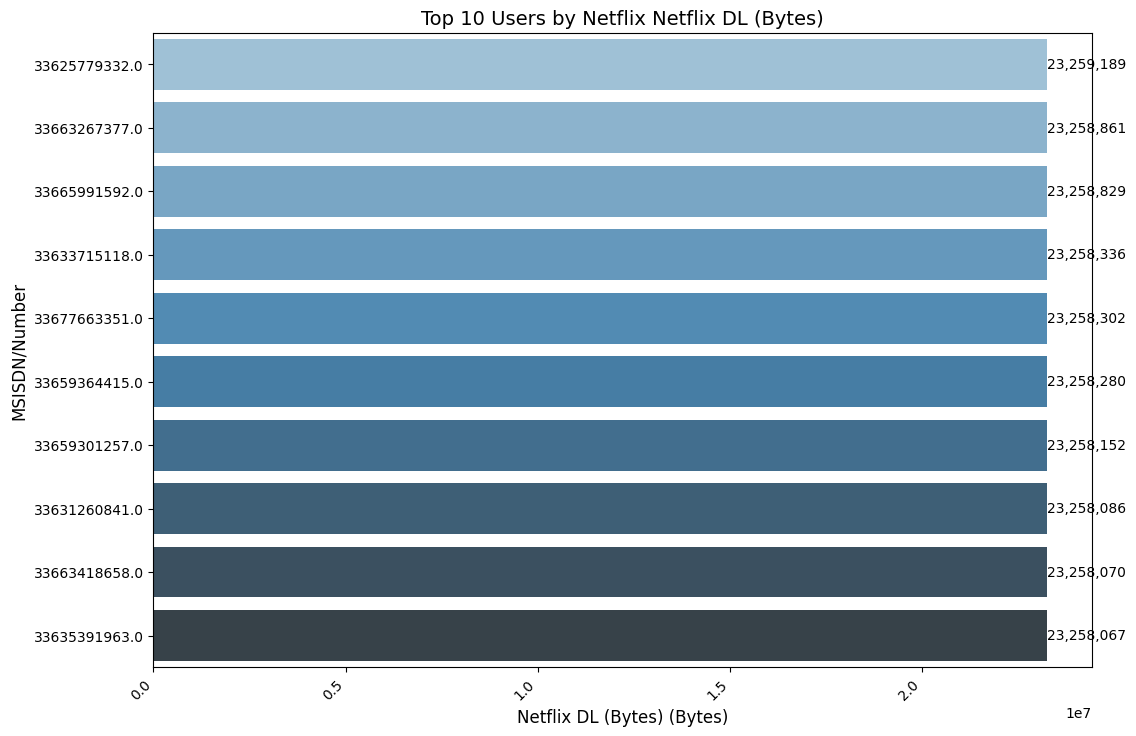

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


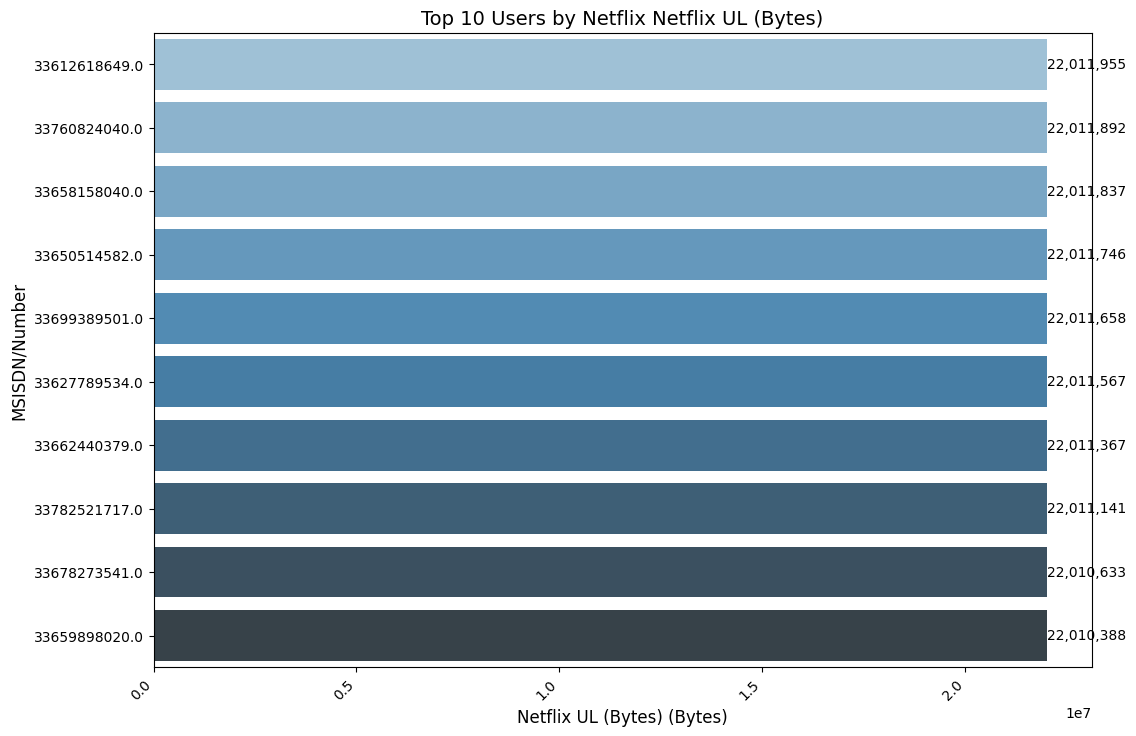

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


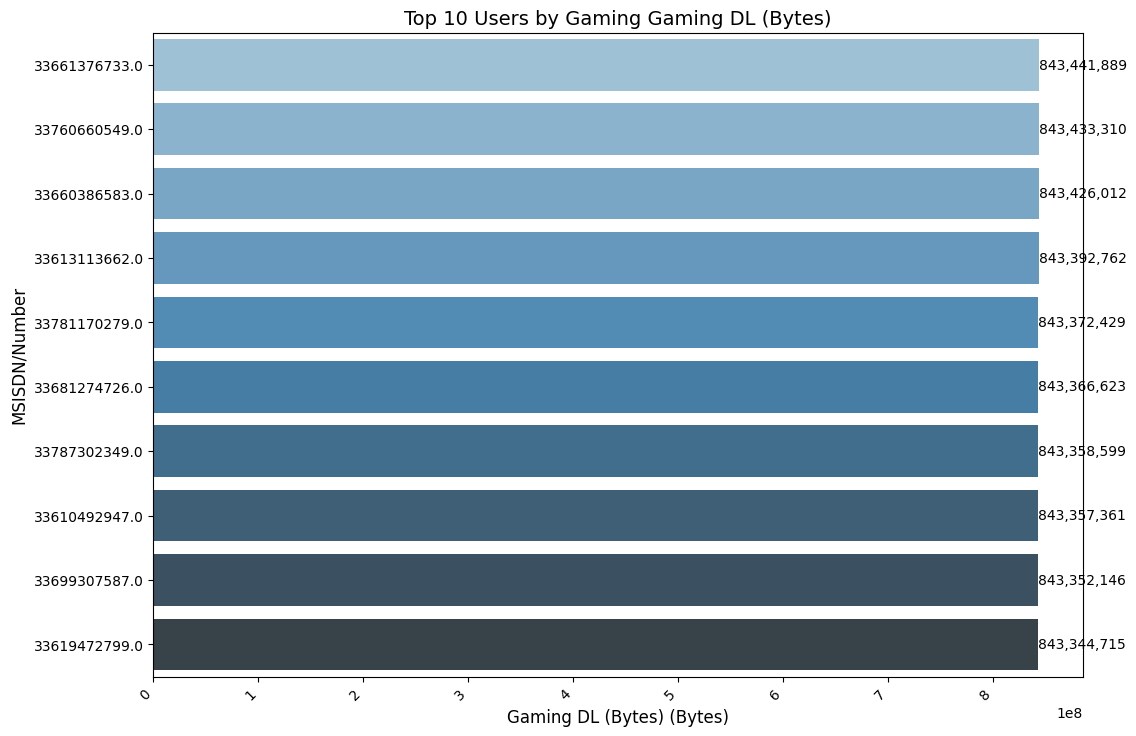

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


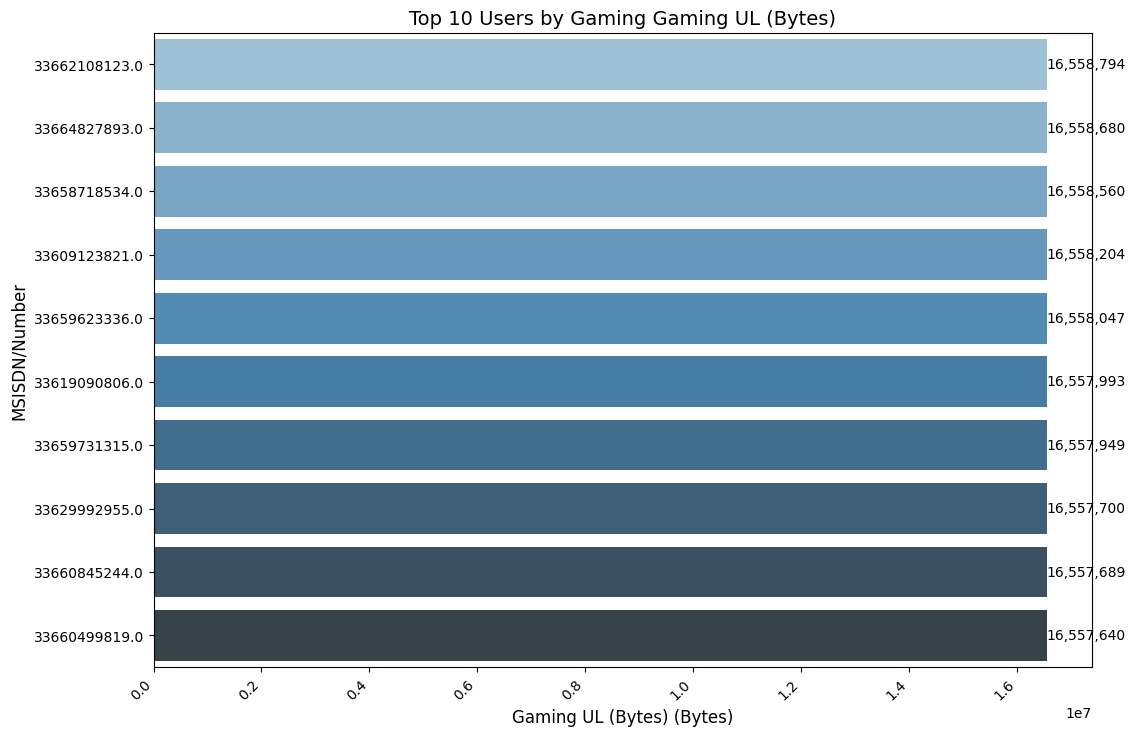

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


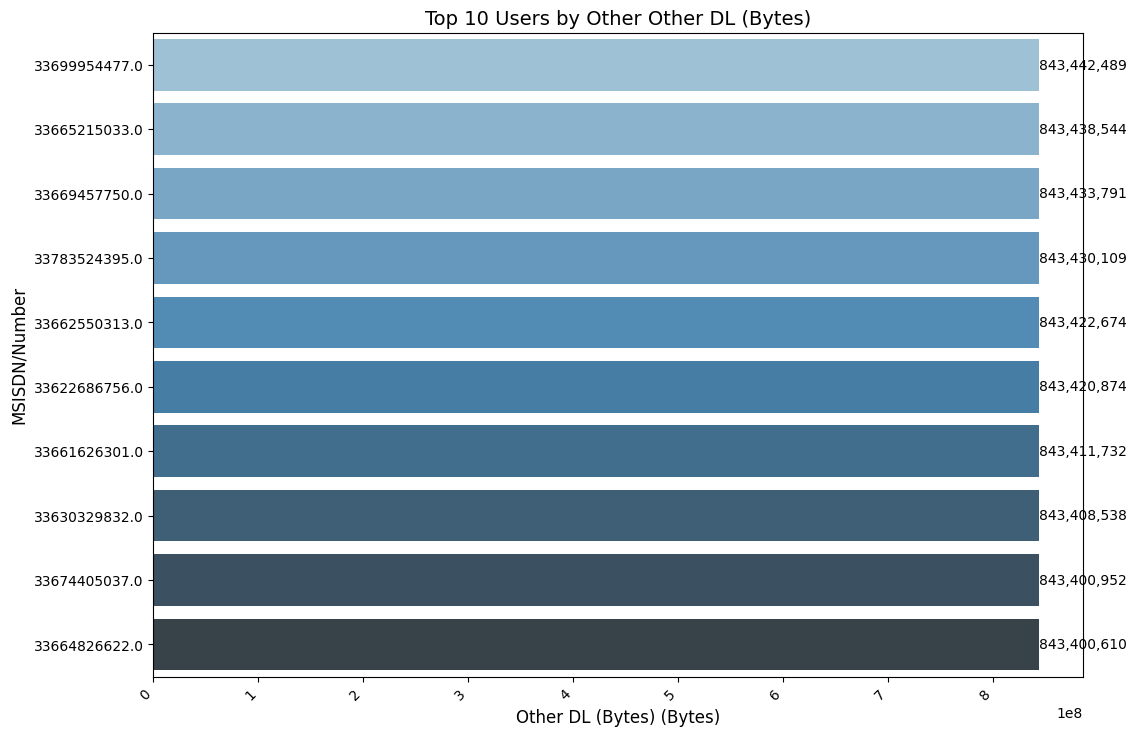

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


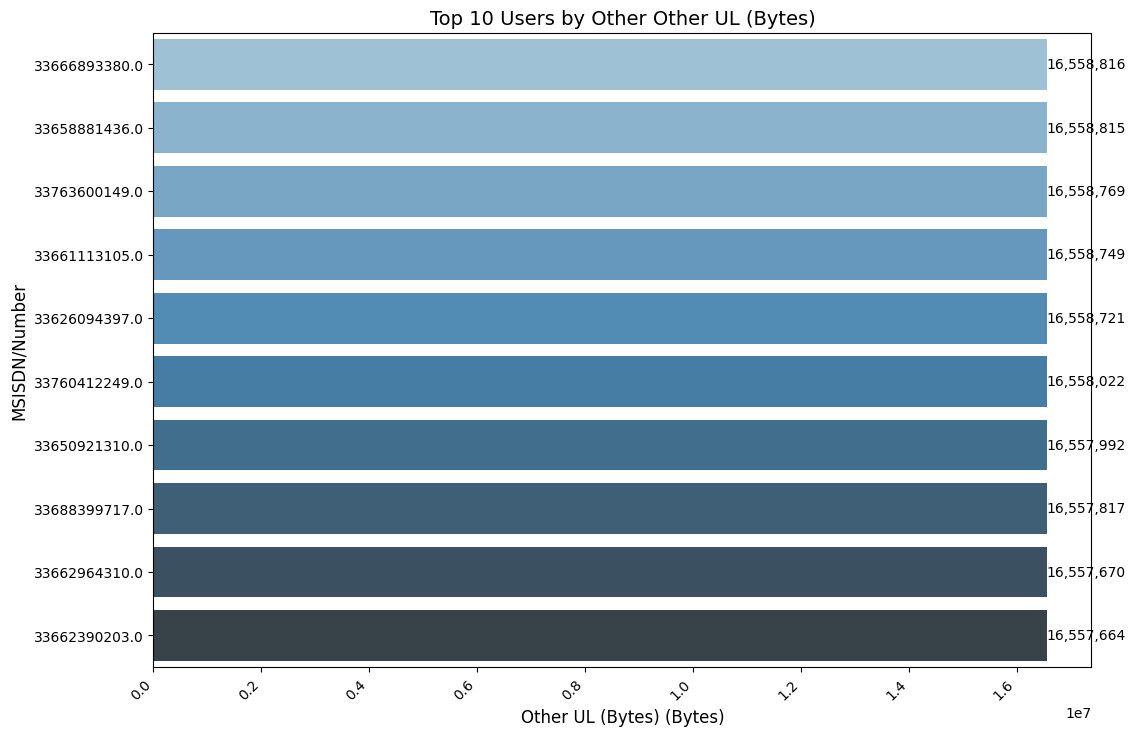

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


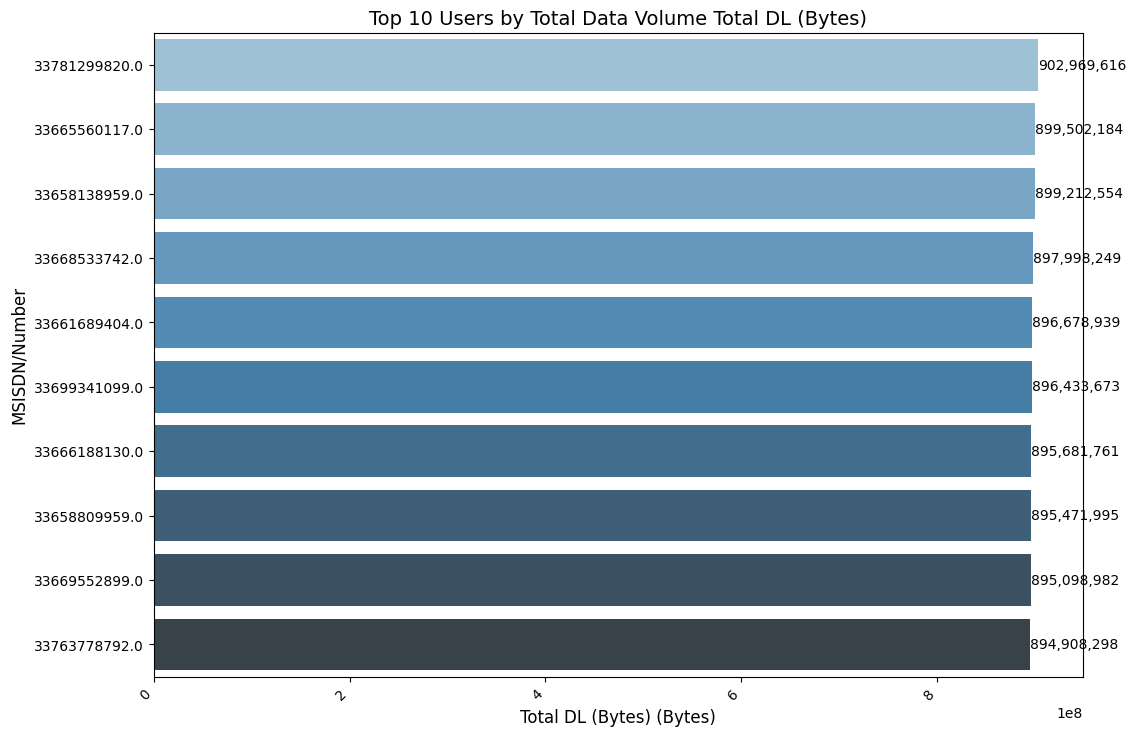

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


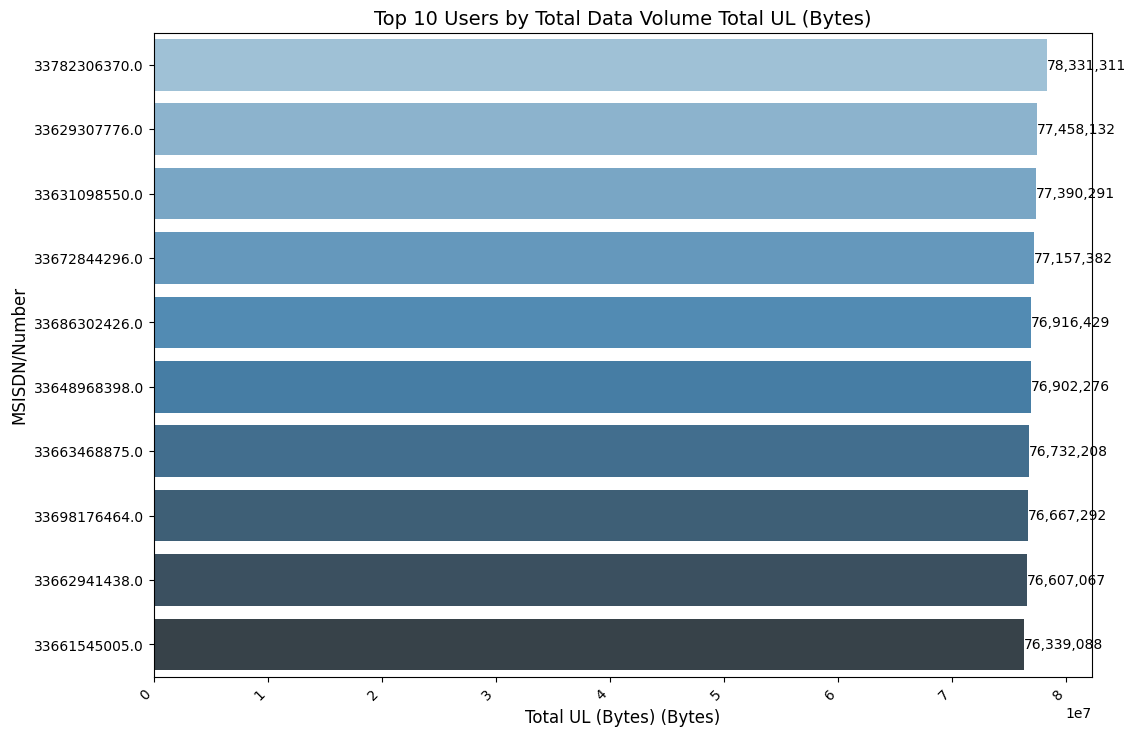

In [23]:


# Visualizing Social Media top 10 users (download and upload)
plot_top_users(top_10_users_social_media_dl, "Social Media", "Social Media DL (Bytes)")
plot_top_users(top_10_users_social_media_ul, "Social Media", "Social Media UL (Bytes)")

# Visualizing Google top 10 users (download and upload)
plot_top_users(top_10_users_google_dl, "Google", "Google DL (Bytes)")
plot_top_users(top_10_users_google_ul, "Google", "Google UL (Bytes)")

# Visualizing Email top 10 users (download and upload)
plot_top_users(top_10_users_email_dl, "Email", "Email DL (Bytes)")
plot_top_users(top_10_users_email_ul, "Email", "Email UL (Bytes)")

# Visualizing Netflix top 10 users (download and upload)
plot_top_users(top_10_users_netflix_dl, "Netflix", "Netflix DL (Bytes)")
plot_top_users(top_10_users_netflix_ul, "Netflix", "Netflix UL (Bytes)")

# Visualizing Gaming top 10 users (download and upload)
plot_top_users(top_10_users_gaming_dl, "Gaming", "Gaming DL (Bytes)")
plot_top_users(top_10_users_gaming_ul, "Gaming", "Gaming UL (Bytes)")

# Visualizing Other top 10 users (download and upload)
plot_top_users(top_10_users_other_dl, "Other", "Other DL (Bytes)")
plot_top_users(top_10_users_other_ul, "Other", "Other UL (Bytes)")

# Visualizing Total Data Volume top 10 users (download and upload)
plot_top_users(top_10_users_total_dl, "Total Data Volume", "Total DL (Bytes)")
plot_top_users(top_10_users_total_ul, "Total Data Volume", "Total UL (Bytes)")


In [24]:
# Calculate total traffic for each application
application_traffic = {
    'YouTube': df['Youtube DL (Bytes)'].sum(),
    'Social Media': df['Social Media DL (Bytes)'].sum(),
    'Google': df['Google DL (Bytes)'].sum(),
    'Netflix': df['Netflix DL (Bytes)'].sum(),
    'Gaming': df['Gaming DL (Bytes)'].sum(),
    'Other': df['Other DL (Bytes)'].sum()
}

# Sort applications by traffic in descending order
sorted_traffic = sorted(application_traffic.items(), key=lambda x: x[1], reverse=True)

# Get the top 3 applications
top_3_apps = sorted_traffic[:3]
print("Top 3 Applications by Traffic:", top_3_apps)


Top 3 Applications by Traffic: [('Gaming', np.float64(63307127434008.59)), ('Other', np.float64(63165502729718.195)), ('YouTube', np.float64(1745122509657.504))]


d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\visualizations.py:333: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=app_names, y=traffic_values, palette="Blues_d")


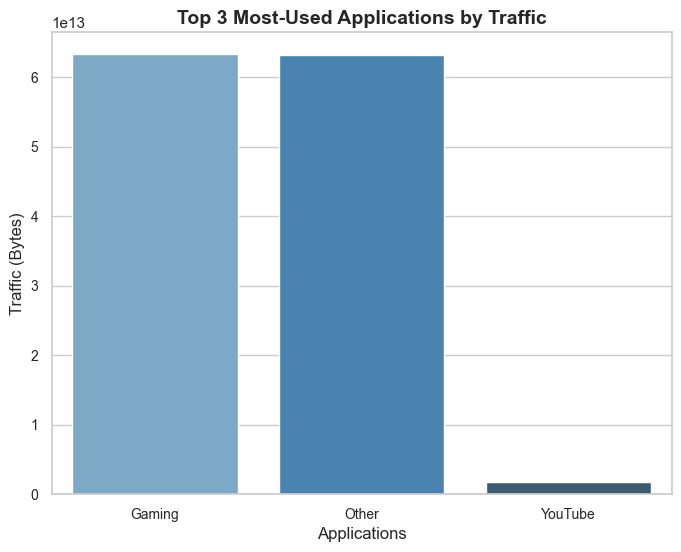

In [25]:
# Call the function
plot_top_3_apps(top_3_apps)

In [26]:


# Select engagement metrics
engagement_metrics = df[['Activity Duration DL (ms)', 'Activity Duration UL (ms)', 
                         'Total DL (Bytes)', 'Total UL (Bytes)']]

# Standardize the data for clustering
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(engagement_metrics)


In [27]:

# Load and preprocess the data
columns_of_interest = ["Social Media DL (Bytes)", "Google DL (Bytes)", "Email DL (Bytes)", "Youtube DL (Bytes)", "Netflix DL (Bytes)"]
selected_data = df[columns_of_interest].fillna(0)




In [28]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)



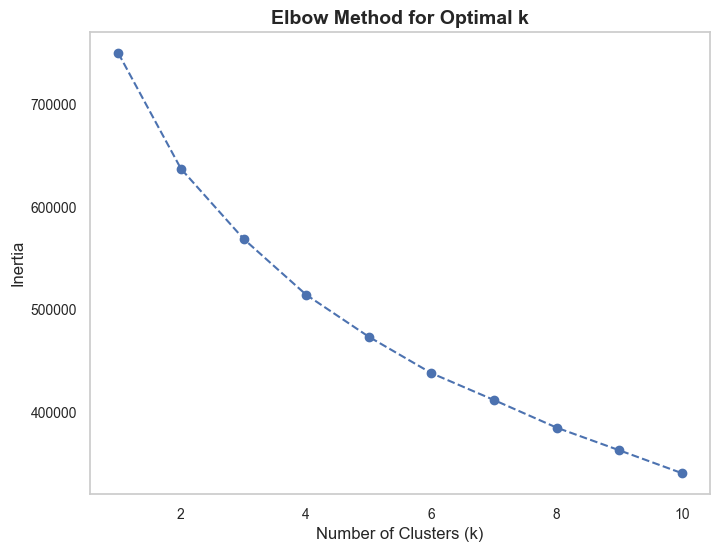

In [29]:
# Determine the optimal value of k using the elbow method
k_range = range(1, 11)
inertia_values = calculate_inertia(scaled_data, k_range)
plot_elbow_curve(list(k_range), inertia_values)



In [30]:
# From the elbow curve, choose the optimal k (e.g., 3)
optimal_k = 3

# Perform k-means clustering
cluster_labels = perform_kmeans_clustering(scaled_data, optimal_k)



In [31]:
# Add the cluster labels back to the original data
df["Cluster"] = cluster_labels



In [32]:
# Interpret the results
cluster_summary = df.groupby("Cluster")[columns_of_interest].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         Social Media DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
Cluster                                                                 
0                   1.796056e+06       5.776994e+06      1.787230e+06   
1                   1.782221e+06       5.747423e+06      1.805142e+06   
2                   1.810292e+06       5.728934e+06      1.780087e+06   

         Youtube DL (Bytes)  Netflix DL (Bytes)  
Cluster                                          
0              1.779387e+07        7.184488e+06  
1              1.186901e+07        1.868410e+07  
2              5.295019e+06        7.542324e+06  
